資料集

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gti-upm/leapgestrecog")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'leapgestrecog' dataset.
Path to dataset files: /kaggle/input/leapgestrecog


調整資料集位置

In [2]:
import os
import shutil

src_root = "/kaggle/input/leapgestrecog/leapGestRecog"
dst_root = "/kaggle/working/data/leapGestRecog"  # Kaggle Notebook 可寫區

os.makedirs(dst_root, exist_ok=True)

for seq_folder in os.listdir(src_root):
    seq_path = os.path.join(src_root, seq_folder)
    if os.path.isdir(seq_path):
        for gesture_folder in os.listdir(seq_path):
            gesture_path = os.path.join(seq_path, gesture_folder)
            dst_gesture_path = os.path.join(dst_root, gesture_folder)
            os.makedirs(dst_gesture_path, exist_ok=True)
            # 只複製檔案，忽略資料夾
            for item in os.listdir(gesture_path):
                src_file = os.path.join(gesture_path, item)
                if os.path.isfile(src_file):  # <-- 確認是檔案
                    dst_file = os.path.join(dst_gesture_path, item)
                    shutil.copy(src_file, dst_file)

print("資料夾 flatten 完成")

資料夾 flatten 完成


套件與 GPU 設定

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


資料前處理

In [4]:
input_size = 64  # 對應 CNN input_size

transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder("/kaggle/working/data/leapGestRecog", transform=transform)

# 80% train / 20% val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

建立 CNN 模型

In [5]:
class GestureCNN(nn.Module):
    def __init__(self, num_classes=10, input_size=64):
        super(GestureCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        conv_out_size = 64 * (input_size // 4) * (input_size // 4)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = GestureCNN(num_classes=len(dataset.classes), input_size=input_size).to(device)

損失函數 & 優化器

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

訓練

In [7]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(imgs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.7704
Epoch 2, Loss: 0.0845
Epoch 3, Loss: 0.0478
Epoch 4, Loss: 0.0360
Epoch 5, Loss: 0.0281
Epoch 6, Loss: 0.0259
Epoch 7, Loss: 0.0207
Epoch 8, Loss: 0.0181
Epoch 9, Loss: 0.0134
Epoch 10, Loss: 0.0162


驗證模型

In [8]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Validation Accuracy: {100*correct/total:.2f}%")

Validation Accuracy: 99.97%


單張影像測試

Predicted class: 02_l


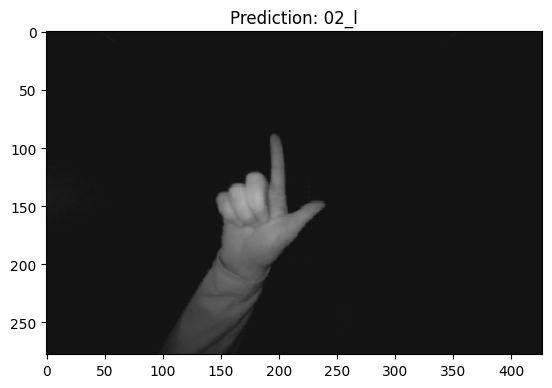

In [9]:
img_path = "/kaggle/test/test.png"
img = Image.open(img_path).convert("RGB")
img_t = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred = model(img_t)
    class_id = torch.argmax(pred, dim=1).item()

print("Predicted class:", dataset.classes[class_id])
plt.imshow(img)
plt.title(f"Prediction: {dataset.classes[class_id]}")
plt.show()